# Intro

# Libraries

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.a2c import A2C, MlpPolicy
import scipy.stats as st
import gc

import src.algorithms.algo_utils as autil
from src.envs.resource_allocation_env import DiscreteProjectsEnv, DiscreteProjectOptimizerAgent


# Env setup

In [4]:
ENV_SIZE = 300

In [19]:
env = DiscreteProjectsEnv(
        start_resource=100,
        start_cash=100,
        upkeep_cost=-1,
        min_payout=-0.5,
        max_payout=1.5,
        payout_mean=1.,
        payout_std=1.5,
        size=ENV_SIZE,
        balance_is_reward=False,
        stochastic=True)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n

C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Agents

In [20]:
class BaselinesWrapper:

    def __init__(self, baselines_agent):
        self.agent = baselines_agent

    def choose_action(self, s: np.array, *args, **kwargs) -> Tuple[np.array, np.array]:
        return self.agent.predict(s)

In [21]:
gc.collect()
dummy_agent = DiscreteProjectOptimizerAgent(env)
ppo_policy_kwargs = dict(net_arch=[dict(pi=[128, 128, 128], vf=[64, 64])])
ppo_agent = PPO(MlpPolicy, env, policy_kwargs=ppo_policy_kwargs, verbose=1, ent_coef=0.001)
a2c_agent = A2C(MlpPolicy, env, policy_kwargs=ppo_policy_kwargs, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
ppo_agent.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=128, out_features=9, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

# Evaluate before training

In [23]:
dummy_scores = autil.evaluate_algorithm(dummy_agent, env, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)
ppo_scores_before = autil.evaluate_algorithm(BaselinesWrapper(ppo_agent), env, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)
a2c_scores_before = autil.evaluate_algorithm(BaselinesWrapper(a2c_agent), env, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

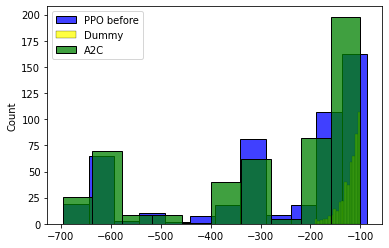

In [24]:
sns.histplot(ppo_scores_before, color='blue', label='PPO before')
sns.histplot(dummy_scores, color='yellow', label='Dummy')
sns.histplot(a2c_scores_before, color='green', label='A2C')
plt.legend()

In [25]:
pd.Series(dummy_scores).describe()

count    500.000000
mean    -120.884226
std       19.246285
min     -191.678297
25%     -128.645939
50%     -115.102402
75%     -105.970494
max     -100.092207
dtype: float64

# Train agent

In [26]:
ppo_agent.learn(total_timesteps=200000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.25     |
|    ep_rew_mean     | -270     |
| time/              |          |
|    fps             | 1375     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.25       |
|    ep_rew_mean          | -214       |
| time/                   |            |
|    fps                  | 1045       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.05991046 |
|    clip_fraction        | 0.459      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.16      |
|    explained_variance   | 0.000971   |
|    learning_rate        | 0.0003     |
|   

In [27]:
a2c_agent.learn(total_timesteps=200000)

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 6.68     |
|    ep_rew_mean        | -204     |
| time/                 |          |
|    fps                | 808      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.801   |
|    explained_variance | 0.111    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -26.3    |
|    value_loss         | 1.19e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 10.2     |
|    ep_rew_mean        | -183     |
| time/                 |          |
|    fps                | 812      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|

# Eval after train

In [28]:
ppo_scores_after = autil.evaluate_algorithm(BaselinesWrapper(ppo_agent), env, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
a2c_scores_after = autil.evaluate_algorithm(BaselinesWrapper(a2c_agent), env, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

# Compare results

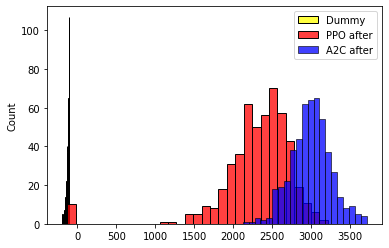

In [30]:
sns.histplot(dummy_scores, color='yellow', label='Dummy')
sns.histplot(ppo_scores_after, color='red', label='PPO after')
sns.histplot(a2c_scores_after, color='blue', label='A2C after')
plt.legend()

In [31]:
result_df = pd.DataFrame({
    'A2C_after': a2c_scores_after,
    'PPO after': ppo_scores_after,
    'baseline': dummy_scores, })
result_df.describe()

,A2C_after,PPO after,baseline
count,500.000000,500.000000,500.000000
mean,2998.497752,2308.710746,-120.884226
std,252.085974,479.504777,19.246285
min,2125.837427,-129.583261,-191.678297
25%,2844.537942,2139.081007,-128.645939
50%,3003.317269,2377.029416,-115.102402
75%,3148.881123,2579.372042,-105.970494
max,3717.015998,3217.755813,-100.092207


In [32]:
stat, pval = st.levene(*[result_df[c] for c in result_df.columns])
pval.round(4)

0.0

In [33]:
melted_df = result_df.melt(var_name='model')
result = pg.welch_anova(melted_df, dv='value', between='model')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,model,2,670.252886,44327.812641,0.0,0.948216


In [34]:
pg.pairwise_gameshowell(melted_df, dv='value', between='model', effsize='cohen')

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,A2C_after,PPO after,2998.497752,2308.710746,689.787006,24.226934,28.471907,755.255583,0.001,1.800721
1,A2C_after,baseline,2998.497752,-120.884226,3119.381979,11.306437,275.894342,504.817177,0.001,17.449090
2,PPO after,baseline,2308.710746,-120.884226,2429.594973,21.461372,113.207811,500.607820,0.001,7.159891
